In [13]:
import csv
import pandas as pd
import json
from pathlib import Path
import math
import matplotlib.pyplot as plt  # This cell is used to import python libraries to visualize the analysis outputs.
import matplotlib.image as mpimg
from matplotlib.widgets import Cursor
import matplotlib.pylab as plb
import matplotlib as mpl
import pandas as pd
import numpy as np
import contextily as ctx
import pyomo
import warnings
import mplcursors
import copy
import os
from pyincore import Dataset, DataService
from pyincore import HazardService
from pyincore import IncoreClient
from pyincore import FragilityService
from pyincore_viz.plotutil import PlotUtil as plot
from pyincore.models.fragilitycurveset import FragilityCurveSet
from pyincore_viz.plotutil import PlotUtil as frag_plot
from pyincore_viz.geoutil import GeoUtil as viz
from pyincore import Mapping, MappingSet, StandardFragilityCurve
from pyincore import ConditionalStandardFragilityCurve, PeriodStandardFragilityCurve
from pyincore.analyses.buildingdamage import BuildingDamage
from pyincore.analyses.montecarlofailureprobability import MonteCarloFailureProbability 
from pyincore.analyses.populationdislocation import PopulationDislocation, PopulationDislocationUtil
from pyincore.analyses.buildingfunctionality import BuildingFunctionality
import palettable.colorbrewer

os.chdir("/Users/yunjiewen/Desktop/JOPLIN/Test_results")
warnings.filterwarnings('ignore')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/yunjiewen/Desktop/JOPLIN/Test_results'

### self-defined function

In [3]:
def population_dislocation(building_dmg_result):
    """
    This function is to calcuate the population dislocation from a troando event.
    input:
    building_dmg_result: INCORE data from building damage analysis
    Return:
    df_dislocaiton_res: dataframe of population dislocaiton results
    """
    # data input
    client.clear_cache()
    housing_unit_alloc = "5dc1c196b9219c06dd2e3f0b"
    bg_data = "5d4c9545b9219c0689b2358a"
    value_loss = "60354810e379f22e16560dbd"
    
    # Create Population dislocation analysis
    pop_dis = PopulationDislocation(client)
    
    # Load analysis input datasets
    pop_dis.load_remote_input_dataset("housing_unit_allocation", housing_unit_alloc)
    pop_dis.load_remote_input_dataset("block_group_data", bg_data)
    pop_dis.load_remote_input_dataset("value_poss_param", value_loss)
    pop_dis.set_input_dataset("building_dmg", building_dmg_result)  # Load the Joplin building damage results dataset
    
    seed = 1111
    pop_dis.set_parameter("result_name", "pop-dislocation-results")
    pop_dis.set_parameter("seed", seed)
    
    #results:
    pop_dis.run_analysis()

    # Retrieve result dataset
    dislocation_result = pop_dis.get_output_dataset("result")

    # Convert dataset to Pandas DataFrame
    df_dislocaiton = dislocation_result.get_dataframe_from_csv(low_memory=False)
    df_dislocaiton = df_dislocaiton.rename(columns = {'archtype':'archetype'})
#     print(len(list(set(df_dislocaiton.blockid))))
#     print(df_dislocaiton.shape)
    #df_dislocaiton_res = bldg_res.merge(df_dislocaiton,on=('guid','archetype','blockid'),how='left')
    df_dislocaiton_res = df_dislocaiton[(df_dislocaiton['archetype']==1)|(df_dislocaiton['archetype']==5)]
#     print(len(list(set(df_dislocaiton_res.blockid))))
#     print(df_dislocaiton_res.shape)
    # calculate the dislocated populaiton
    populaiton_dislocaiton= df_dislocaiton_res[df_dislocaiton_res['dislocated']==True]['numprec'].sum()
    
    #print(df_dislocaiton .columns)
    return  populaiton_dislocaiton

In [4]:
def building_damage_without_retrofit(hazard_id,fragilityMappingSet):
    """
    This funciton is to calculate the building damage without retrofitting implemented
    from a troando event by using INCORE service
    input:
    hazard: INCORE hazard id
    fragilityMappingSet: INCORE fragility Mapping data
    Return:
    building_dmg_result: INCORE data type of building damage result 
    df_building_dmg: dataframe of building damage result
    
    """
    
    bldg_dmg = BuildingDamage(client)

    # result name
    result_name = "tornado_dmg_result_no_retrofit" + hazard_id
    # building damage analysis through INCORE service
    bldg_dmg.load_remote_input_dataset("buildings", bldg_dataset_id)
    bldg_dmg.set_input_dataset('dfr3_mapping_set', mapping_set_no_retrofit)
    bldg_dmg.set_parameter("fragility_key", "Non-Retrofit Fragility ID Code") # without retrofitting, check the Mapping object
    bldg_dmg.set_parameter("result_name", result_name)
    bldg_dmg.set_parameter("hazard_type", hazard_type)
    bldg_dmg.set_parameter("hazard_id", hazard_id)
    bldg_dmg.set_parameter("num_cpu", 4)
    bldg_dmg.run_analysis()

    
    #results
    building_dmg_result = bldg_dmg.get_output_dataset('ds_result')
    # Convert dataset to Pandas DataFrame
    df_building_dmg = building_dmg_result.get_dataframe_from_csv()
    
    return  building_dmg_result,df_building_dmg

In [5]:
def building_damage_with_retrofit(hazard_id,fragilityMappingSet,retrofit_data):
    """
    This funciton is to calculate the building damage with retrofitting implemented
    from a troando event by using INCORE service
    input:
    hazard: INCORE hazard id
    fragilityMappingSet: INCORE fragility Mapping data
    retrofit_data: INCORE dataset of retrofit data
    retrofit_level: string, retrofit level
    Return:
    building_dmg_result: INCORE data type of building damage result 
    df_building_dmg: dataframe of building damage result
    
    """
    
    bldg_dmg = BuildingDamage(client)

    # result name
    result_name = "tornado_dmg_result_retrofit"
    # building damage analysis through INCORE service
    bldg_dmg.load_remote_input_dataset("buildings", bldg_dataset_id)
    bldg_dmg.set_input_dataset("retrofit_strategy", retrofit_data)
    bldg_dmg.set_input_dataset('dfr3_mapping_set', mapping_set_with_retrofit)
    bldg_dmg.set_parameter("fragility_key", "Fragility ID Code") # use it when use retrofit mapping
    bldg_dmg.set_parameter("result_name", result_name)
    bldg_dmg.set_parameter("hazard_type", hazard_type)
    bldg_dmg.set_parameter("hazard_id", hazard_id)
    bldg_dmg.set_parameter("num_cpu", 4)
    bldg_dmg.run_analysis()

    #results
    building_dmg_result = bldg_dmg.get_output_dataset('ds_result')
    # Convert dataset to Pandas DataFrame
    df_building_dmg = building_dmg_result.get_dataframe_from_csv()
    
    return  building_dmg_result,df_building_dmg

In [6]:
def MC_building_damage(number_samples,building_dmg_result):
    """
    This function is to calculte the building damage using Metro Carlo simulation
    input:
    retrofit_level: integer, simulation sample numnber
    building_dmg_result: INCORE datatype, building damage result
    
    Return:
    building_failure_probability: INCORE datatype of building failure results
    df_bldg_fail: dataframe, building failure results
    
    """
    
    mc_bldg = MonteCarloFailureProbability(client)
    
    num_samples = number_samples
    result_name = "tornado_mc_failure_probability_buildings"
    
    mc_bldg.set_input_dataset("damage", building_dmg_result)                                                          
    mc_bldg.set_parameter("num_cpu", 8)
    mc_bldg.set_parameter("num_samples", num_samples)
    mc_bldg.set_parameter("damage_interval_keys", ["DS_0", "DS_1", "DS_2", "DS_3"])
    mc_bldg.set_parameter("failure_state_keys", ["DS_1", "DS_2", "DS_3"])
    mc_bldg.set_parameter("result_name", result_name) 
    mc_bldg.run_analysis()
    # resulrts
    building_failure_probability = mc_bldg.get_output_dataset('failure_probability')  # get buildings failure probabilities
    df_bldg_fail = building_failure_probability.get_dataframe_from_csv()
    return building_failure_probability,df_bldg_fail

### Read retrofit solutions and select retrofit plan

<font size="4"> This section demonstrate that how to select retrofit solution from Pareto plot. The retrofit solutions are producded from the optimizal model intergrating three objective functions: direct economic loss, population dislocation, building functionality for residential buildings in joplin. The retrofitting budget is 181M dollar and the number of epsilon step is 20. The total number of solution is 109.  <font>

In [7]:
# Pareto objective function data
pareto_solutions = pd.read_csv("/Users/yunjiewen/Desktop/Retrofit_notebook/Budge_20_0513_2021_Objectivs.csv")

In [8]:
# extract objective values from the dataframe
eco_loss = (pareto_solutions['Economic_loss']/1565).tolist()
popu_dis = (pareto_solutions['Dislocation']/1565).tolist()
func = pareto_solutions['Functionality'].tolist()
solutions_id = pareto_solutions['Solution_id'].tolist()

Text(0, 0.5, 'Average Population Dislocation per block group')

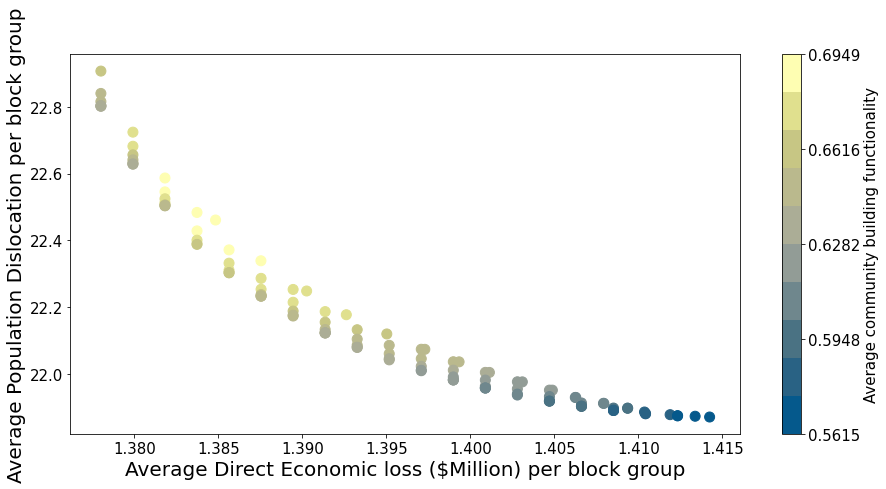

In [10]:
%matplotlib inline
# Visualize the Pareto objective values
cm1 = mpl.colors.ListedColormap(palettable.scientific.sequential.Nuuk_10.mpl_colors)

plt.figure(figsize=(15,7))
plt.scatter(eco_loss,popu_dis,c=func,cmap=cm1,s=100)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# color bar setting
v1 = np.linspace(min(func), max(func), 5, endpoint=True)
norm = mpl.colors.BoundaryNorm(v1, cm1.N,clip=True)

cb1 = plt.colorbar(ticks = v1)
cb1.set_label(label='Average community building functionality',size=15)
cb1.ax.tick_params(labelsize=15)
plt.clim(min(func), max(func))
plt.xlabel("Average Direct Economic loss ($Million) per block group",fontsize = 20)
plt.ylabel("Average Population Dislocation per block group",fontsize = 20)


Text(0, 0.5, 'Average community building functionality')

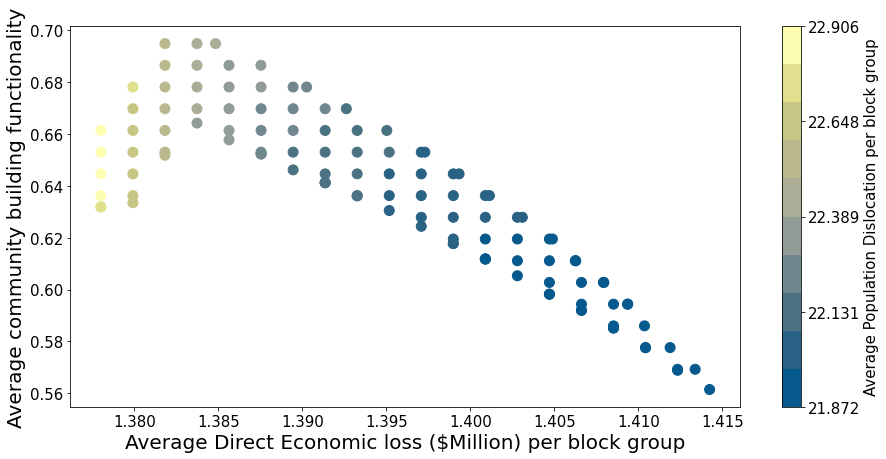

In [12]:
%matplotlib inline
# Visualize the Pareto objective values
cm1 = mpl.colors.ListedColormap(palettable.scientific.sequential.Nuuk_10.mpl_colors)

plt.figure(figsize=(15,7))
plt.scatter(eco_loss,func,c=popu_dis,cmap=cm1,s=100)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# color bar setting
v1 = np.linspace(min(popu_dis), max(popu_dis), 5, endpoint=True)
norm = mpl.colors.BoundaryNorm(v1, cm1.N,clip=True)

cb1 = plt.colorbar(ticks = v1)
cb1.set_label(label='Average Population Dislocation per block group',size=15)
cb1.ax.tick_params(labelsize=15)
plt.clim(min(popu_dis), max(popu_dis))
plt.xlabel("Average Direct Economic loss ($Million) per block group",fontsize = 20)
plt.ylabel("Average community building functionality",fontsize = 20)

<font size="4">Each point in the Pareto plot reprents a optimal solution. Users can use the Solution id to find the retrofit solution from all the solution produced from the optimization model. </font>

<IPython.core.display.Javascript object>


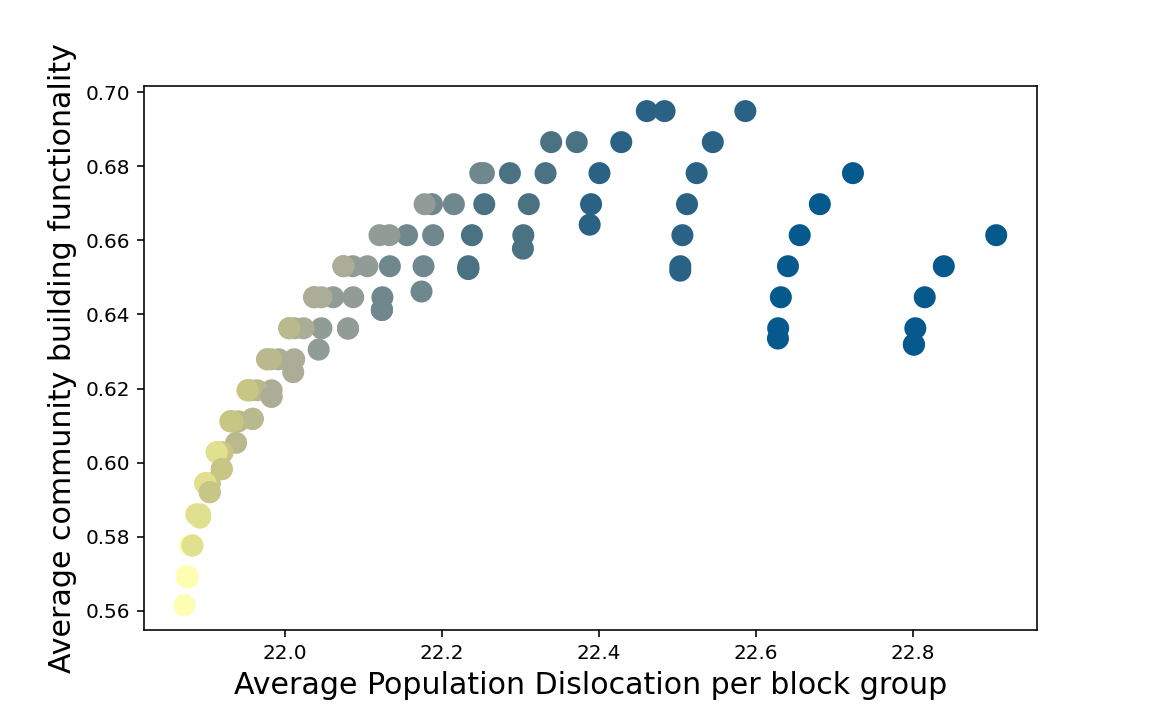

In [13]:
# Visualize the Pareto objective values
%matplotlib notebook
cm1 = mpl.colors.ListedColormap(palettable.scientific.sequential.Nuuk_10.mpl_colors)

fig, ax = plt.subplots(figsize=(8,5))
pareto = ax.scatter(popu_dis,func,c=eco_loss,cmap=cm1,s=100)
plt.ylabel("Average community building functionality",fontsize = 15)
plt.xlabel("Average Population Dislocation per block group",fontsize = 15)
fig.canvas.mpl_connect(
    "motion_notify_event",
    lambda event: fig.canvas.toolbar.set_message(""))
cursor = mplcursors.cursor(hover=True)
cursor.connect(
    "add",
    lambda sel: fig.canvas.toolbar.set_message(
        sel.annotation.get_text().replace("\n", "; ")))
plt.show()
# to-do population dislocation/ blockid groups

In [14]:
selected_popu = min(popu_dis)
selected_func = func[popu_dis.index(selected_popu)]
solution_id_selected = solutions_id[popu_dis.index(selected_popu)]

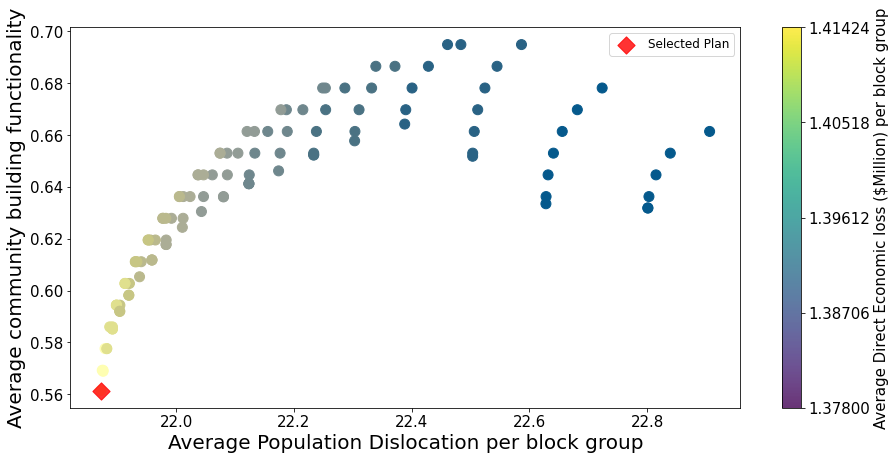

In [15]:
# color theme
%matplotlib inline
cm1 = mpl.colors.ListedColormap(palettable.scientific.sequential.Nuuk_10.mpl_colors)

plt.figure(figsize=(15,7))
plt.scatter(popu_dis,func,c=eco_loss,cmap=cm1,s=100)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
p1 = plt.scatter(selected_popu,selected_func,color = 'red',s = 150,marker ='D',alpha=0.8,label='Selected Plan')
# color bar setting
v1 = np.linspace(min(eco_loss), max(eco_loss), 5, endpoint=True)
norm = mpl.colors.BoundaryNorm(v1, cm1.N,clip=True)

cb1 = plt.colorbar(ticks = v1)
cb1.set_label(label='Average Direct Economic loss ($Million) per block group',size=15)
cb1.ax.tick_params(labelsize=15)
plt.clim(min(eco_loss), max(eco_loss))
plt.legend(fontsize=12)
plt.ylabel("Average community building functionality",fontsize = 20)
plt.xlabel("Average Population Dislocation per block group",fontsize = 20)

plt.show()

In [16]:
solutions = pd.read_csv("/Users/yunjiewen/Desktop/Retrofit_notebook/decision_variable_B20.csv")

In [17]:
solution_id_selected

19

In [18]:
selected_plan = solutions[(solutions["Solution_id"]==solution_id_selected)]
selected_plan.head()

,Solution_id,Number_buildings,Z,S,K
0,19,0.0,290970101001000,1,0
1,19,0.0,290970101001000,1,1
2,19,0.0,290970101001000,1,2
3,19,5.0,290970101001000,1,3
4,19,0.0,290970101001001,1,0


### INCORE Login and load INCORE module

In [45]:
client = IncoreClient()
client.clear_cache()
bldg_dmg = BuildingDamage(client)
data_services = DataService(client)

Connection successful to IN-CORE services. pyIncore version detected: 1.0.0


### Create IN-CORE data file for retrofit plan 1

<font size="4"> This section provides steps for creating retorfitting data <font>

In [46]:
# read dataset from INCORE
building_dataset_id = "5dbc781db9219c06dd2429ca"
building_Joplin = Dataset.from_data_service(building_dataset_id, data_services)
building_inv = building_Joplin.get_dataframe_from_csv()


In [ ]:
building_inv = building_inv.rename(columns={'archtype':'archetype'})

<font size="4"> The decision level is blockid, but the column 'blockid' in the dataset is not correct and there are only two unique vlaues for 28,152 buildings. As suggested from NCSA, I use column 'blockidstr' and remove the first characts "CB" to replace the 'blockid. Another suggests from NCSA is to use the shapefile data 5dbc8478b9219c06dd242c0d, however, there is no column 'blockid' in the data extracted from the shapefile. <font>

In [ ]:
# The blockid from the dataset is not correct.Use blockidstr 
for i in range (len(building_inv)):
    building_inv['blockidstr'].values[i] = building_inv['blockidstr'].values[i].replace('CB','')
    

In [ ]:
# replace blockid with the blockidstr after removing the first two characters
building_inv['blockid'] = building_inv['blockidstr']

In [ ]:
# read retrofit solution
plan1_df = selected_plan[["Z","S","K","Number_buildings"]]

In [ ]:
# sometime the blockid form does not show correctly, this cell just to make sure the blockids are correct
building_inv = building_inv.astype({"blockid":"int64"})
plan1_df  = plan1_df.astype({"Z":"int64"})

In [ ]:
# select the row with Number_buildings > 0, becasue one blockid associated with 4 retrofit strategies in original dataset
plan1_df = plan1_df.rename(columns={'Z':'blockid','S':'archetype','K':'retrofit_method'})
plan1_df = plan1_df[plan1_df["Number_buildings"]!=0]

In [ ]:
# merge two data set to get guid for the building in retrofit plan
plan1_guid = plan1_df.merge(building_inv,on=['blockid','archetype'],how='left')
plan1_guid = plan1_guid.drop_duplicates(subset=['guid'])

In [ ]:
# only select the columns needed for retrofit plan data
plan1_final = plan1_guid[['guid','retrofit_method']]

In [ ]:
plan1_final.groupby('retrofit_method').count().reset_index()

In [ ]:
# Joplin retrofit plan only consider residential buildings, this cell is to define the missing retrofit stategeis 
#for commercial buildings that are needed in MCS
for guid in building_inv.guid.to_list():
    if guid not in plan1_final.guid.to_list():
        plan1_final = plan1_final.append({'guid':guid,
                                          'retrofit_method':0
                                         },ignore_index = True)

In [ ]:
# set the column retrofit_method to integer
plan1_final.retrofit_method = plan1_final.retrofit_method.astype(int)

In [ ]:
# set the data type as str. In INCORE, retrofit plan data form is defined to use " str", 
# make sure your final data form is correct
plan1_final.guid = plan1_final.guid.astype(str)
plan1_final.retrofit_method = plan1_final.retrofit_method.astype(str)

In [ ]:
# guid and retrofit method are string defined by INCORE, adding quotation on both column to comply the data form
plan1_final.to_csv("/Users/yunjiewen/Desktop/Joplin_Analysis_paper_Part2/Tornado_simulation/Test_results/plan1_strategy.csv",
                   quoting=csv.QUOTE_ALL,index=False)

In [ ]:
# "incore:retrofitStrategy" is INCORE data type, you can find it in source code if you don't know
plan1 = Dataset.from_file("/Users/yunjiewen/Desktop/Joplin_Analysis_paper_Part2/Tornado_simulation/Test_results/plan1_strategy.csv",
                          "incore:retrofitStrategy")
plan1

### IN-CORE input

<font size="4"> Input information from INCORE <font>

In [ ]:
# building mapping (with equation)
mapping_id_no_retrofit = "5d8942dfb9219c068ea795ea"  # 19 archetype without retrofit
mapping_id_with_retrofit = "618eaad5c252b35b6384378c" # 19 archetype with retrofit
#mapping_id = "60994a1906d63d5ded1d6dcc" # 19 archetype with retrofit new format mapping
fragility_service = FragilityService(client)
mapping_set_no_retrofit = MappingSet(fragility_service.get_mapping(mapping_id_no_retrofit))
mapping_set_with_retrofit = MappingSet(fragility_service.get_mapping(mapping_id_with_retrofit))

In [ ]:
# load dataframe for optimization retrofit plan 1
bldg_dataset_id = "5dbc8478b9219c06dd242c0d"  # Load the Joplin building dataset retrofit plan1
bldg_dataset= Dataset.from_data_service(bldg_dataset_id, DataService(client))


In [ ]:
# getting geodataframework of building dataset and merge with output
bldg_gdf = bldg_dataset.get_dataframe_from_shapefile()
bldg_gdf.crs = "EPSG:4326"

### Hazard information

In [ ]:
hazard_type = "tornado"
hazard_id = "608c5b17150b5e17064030df" #EF4

In [ ]:
viz.plot_tornado(hazard_id, client, basemap=True)

## Damage Analysis without retrofit

<font size="4"> Damage analysis without any retrofitting on different tornado scenarios. <font>

In [ ]:
# import to clean the cache before the analysis
client.clear_cache()

In [ ]:
# list of simulated tornado event in INCORE
hazards_list = ["602709015b580037c0d40090","60270931cebd090981cbb66d","60270954b02d597160210968",
               "6027096dcebd090981cbb694","602709a0487b8113aaaa3307","602709c8b02d59716021098f",
               "602709f85b580037c0d400b7","60270a36b02d5971602109b6","60270a595b580037c0d400de",
               "60270a825b580037c0d40105","60270db5cebd090981cbb6bb","60270de0cebd090981cbb6e2",
               "60270e08cebd090981cbb709","60270e2db02d59716021163e","60270e48cebd090981cbb730",
               "60270eb3b02d597160211665","60270edecebd090981cbb757","60270f0bb02d59716021168c",
               "60270f2c5b580037c0d4012c","60270f59b02d5971602116b3","601da3ea487b8113aa32ea7a",
               "6026e9f85b580037c0d3dc7e","6026f60e487b8113aaaa15b4","6026f6f0cebd090981cb9800",
               "6026fb74487b8113aaaa15db","6026fffd487b8113aaaa257b","5d07cbeab9219c065b080930",
               "607ef4629dc98f1caad9864a"]  
                              

In [ ]:
dislocation_no_retrofit_list = []
for hazard in hazards_list:
    
    hazard_id = hazard
    # building damage analysis
    building_dmg_result_no_retrofit,df_no_retrofit = building_damage_without_retrofit(hazard_id,mapping_set_no_retrofit)
    # Population dislocation analysis
    popu_dis_no_retrofit = population_dislocation(building_dmg_result_no_retrofit)
    dislocation_no_retrofit_list.append(popu_dis_no_retrofit)
   

## Damage Analysis with retrofit

<font size="4"> Damage analysis with retrofitting plan on different tornado scenarios. <font>

In [ ]:
# import to clean the cache before the analysis
client.clear_cache()

In [ ]:
dislocation_with_retrofit_list = []
for hazard in hazards_list:
    
    hazard_id = hazard
    # building damage analysis
    building_dmg_result_plan1,df_building_dmg_plan1 = building_damage_with_retrofit(hazard_id,mapping_set_with_retrofit,plan1)
    # Population dislocation analysis
    popu_dis_plan1 = population_dislocation(building_dmg_result_plan1)
    dislocation_with_retrofit_list.append( popu_dis_plan1 )
   

### Compare the results

In [ ]:
diff = []
diff_percent = []
for i in range (0,len(dislocation_no_retrofit_list)-1):
    diff.append(dislocation_no_retrofit_list[i] - dislocation_with_retrofit_list[i])
    diff_percent.append((dislocation_no_retrofit_list[i] - dislocation_with_retrofit_list[i])/dislocation_no_retrofit_list[i])
    

In [ ]:
sum(diff_percent)/len(dislocation_no_retrofit_list)